# Postprocessing a DeepONet Trained for a Perfectlt Stirred Reactor

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from tensorflow                           import keras

In [2]:
### Input Data

ROMNetFldr    = WORKSPACE_PATH + '/ROMNet/romnet/'

OutputDir     = WORKSPACE_PATH+'/ROMNet/Data/PSR_10Cases/'
TestDir       = WORKSPACE_PATH+'/ROMNet/Data/PSR_10Cases_Test/'

#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/PSR_10Cases/DeepONet/Deterministic/Run_4/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/PSR_10Cases/DeepONet/MCDropOut/Run_2/'
PathToRunFld  = WORKSPACE_PATH + '/ROMNet/PSR_10Cases/DeepONet/BayesByBackprop/Run_1/'

CasesVec      = [9] 
DirDir        = OutputDir #OutputDir #TestDir

NSamples      = 100

NVarsRed      = 3
TestInputVars = ['PC_1','PC_2','PC_3']

In [3]:
print("\n[ROMNet]: Reading Input File from: ", PathToRunFld)
sys.path.insert(0, PathToRunFld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData                 = inputdata(WORKSPACE_PATH, ROMNetFldr)

InputData.PathToRunFld    = PathToRunFld

InputData.PathToFigFld    = InputData.PathToRunFld+'/Figures/'
print("\n[ROMNet]: Final Figures can be Found here: " + InputData.PathToFigFld)

InputData.PathToParamsFld = InputData.PathToRunFld+'/Params/'
print("\n[ROMNet]: Final Parameters can be Found here: " + InputData.PathToParamsFld)

InputData.TBCheckpointFldr = None


[ROMNet]: Reading Input File from:  /Users/sventuri/WORKSPACE//ROMNet/PSR_10Cases/DeepONet/BayesByBackprop/Run_1/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...

[ROMNet]: Final Figures can be Found here: /Users/sventuri/WORKSPACE//ROMNet/PSR_10Cases/DeepONet/BayesByBackprop/Run_1//Figures/

[ROMNet]: Final Parameters can be Found here: /Users/sventuri/WORKSPACE//ROMNet/PSR_10Cases/DeepONet/BayesByBackprop/Run_1//Params/


In [4]:
### Loading Surrogate

SurrogateType = InputData.SurrogateType
if (SurrogateType == 'FNN-SourceTerms'):
    SurrogateType = 'FNN'

sys.path.insert(0, InputData.ROMNetFldr  + '/src/Model/' + SurrogateType + '/' + InputData.ProbApproach + '/')
from Model import model

InputData.TrainIntFlg = 0

NN = model(InputData, InputData.PathToRunFld, None, None)

NN.load_params(InputData) 



# ModelFile      = InputData.PathToRunFld    + '/NNModel'
# Model          = keras.models.load_model(ModelFile, custom_objects={InputData.LossFunction: None})
# Model.summary()

# MCFile         = InputData.PathToParamsFld + "/ModelCheckpoint/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(MCFile)
# latest         = train.latest_checkpoint(checkpoint_dir)
# Model.load_weights(latest)

[ROMNet]:   Defining ML Model from Scratch


/usr/local/lib/python3.8/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


[ROMNet]:   Compiling ML Model with Loss and Optimizer
[ROMNet]:   Saving ML Model in File: /Users/sventuri/WORKSPACE//ROMNet/PSR_10Cases/DeepONet/BayesByBackprop/Run_1//NNModel
[ROMNet]:   Summarizing ML Model Structure:
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf.split (TFOpLambda)           [(None, 1), (None, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 1)            3           tf.split[0][0]                   
______________________________________________________________________

Total params: 34,846
Trainable params: 34,840
Non-trainable params: 6
__________________________________________________________________________________________________
[ROMNet]:   Loading ML Model Parameters from File:  /Users/sventuri/WORKSPACE//ROMNet/PSR_10Cases/DeepONet/BayesByBackprop/Run_1//Params//ModelCheckpoint/cp-1294.ckpt


In [5]:
LName   = 'Trunk_'+str(1)+'_HL' + str(len(InputData.TrunkActFun[0]))

Trunk = keras.Model(NN.Model.inputs, NN.Model.get_layer(LName).output)
Trunk.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
tf.split (TFOpLambda)        [(None, 1), (None, 1)]    0         
_________________________________________________________________
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
Trunk_1_HL1 (DenseFlipout)   (None, 32)                128       
_________________________________________________________________
Trunk_1_HL2 (DenseFlipout)   (None, 32)                2112      
_________________________________________________________________
Trunk_1_HL3 (DenseFlipout)   (None, 32)                2112      
Total params: 4,355
Trainable params: 4,352
Non-trainable params: 3
_________________________________________________________

In [6]:
# LName   = 'Branch_'+InputData.BranchVars[0]+'_HL' + str(len(InputData.TrunkActFun[0]))
# '_HL' + str(len(InputData.BranchActFun[0]))

# Branch1 = keras.Model(NN.Model.inputs, NN.Model.get_layer(LName).output)
# Branch1.summary()

In [7]:
# LName   = 'Branch_'+InputData.BranchVars[1]+'_HL' + str(len(InputData.BranchActFun[1]))

# Branch2 = keras.Model(NN.Model.inputs, NN.Model.get_layer(LName).output)
# Branch2.summary()

In [8]:
FileName = OutputDir+'/pca_'+str(NVarsRed)+'/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/pca_'+str(NVarsRed)+'/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/pca_'+str(NVarsRed)+'/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

iVar =  15
iVar =  15
RestVal =  [-4.] ; y0_pca =  [ 3.42441839e+02 -1.78877349e-02  2.89325323e-03]


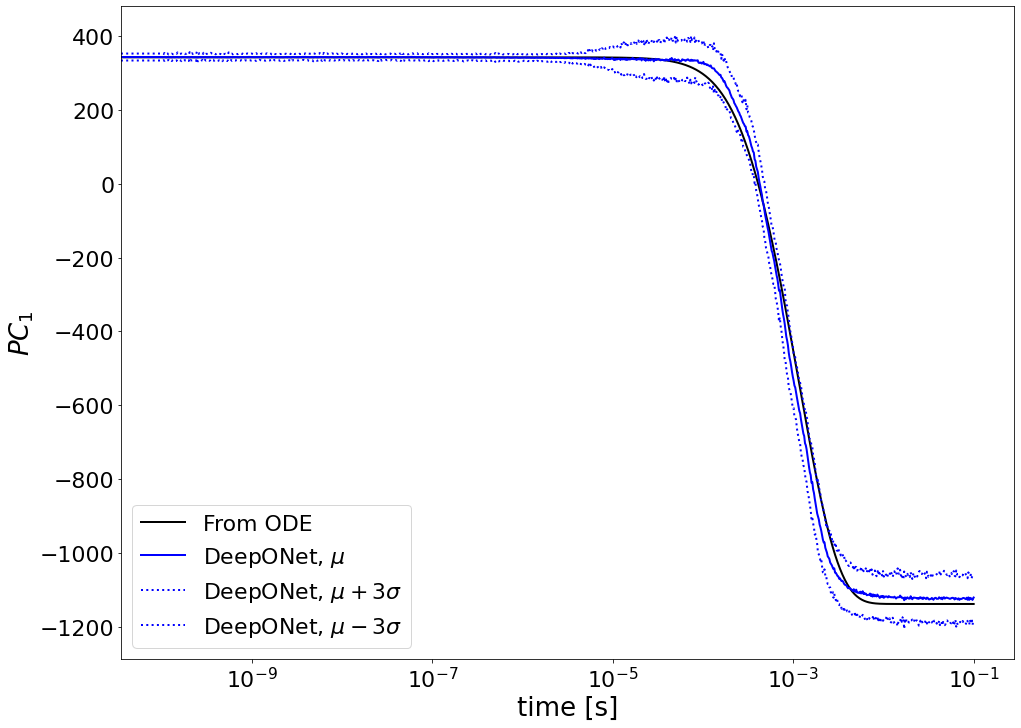

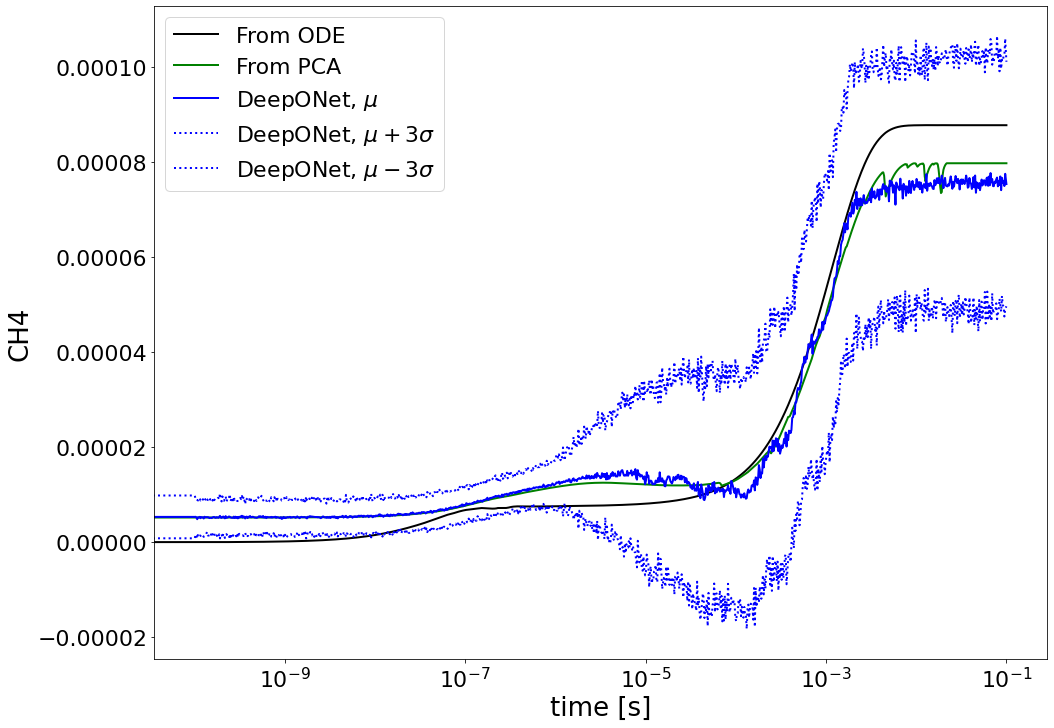

In [9]:
### Evaluating on Test Data

VarOI    = 'CH4'


FileName = DirDir + '/orig_data/y.csv.1'
Data     = pd.read_csv(FileName, header=0)
VarNames = list(Data.columns)
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break
        

FileName   = DirDir + '/orig_data/CleanVars.csv'
Data       = pd.read_csv(FileName, header=0)
VarNamesPC = list(Data.columns)
for iVarPC in range(1,len(VarNames)):
    if (VarNames[iVarPC] == VarOI):
        print('iVar = ', iVarPC)
        break
        
        
FileName       = DirDir + '/orig_data/ResidenceTimes.csv'
Data           = pd.read_csv(FileName, header=None)
RestValVecTest = np.log10(Data.to_numpy())

iPC = 0

ax  = []

fig = plt.figure(figsize=(16,12))
ax.append(plt.axes())

fig = plt.figure(figsize=(16,12))
ax.append(plt.axes())
for iTest in CasesVec:
    RestVal                      = RestValVecTest[iTest]

    FileName                     = DirDir+'/pc_data_'+str(NVarsRed)+'/PC.csv.'+str(iTest+1)
    InputDataTest                = pd.read_csv(FileName, header=0)
    tVec                         = InputDataTest['t'].to_numpy()
    InputDataTest['log10(t)']    = np.log10(tVec + 1.e-20)
    InputDataTest['log10(Rest)'] = RestVal * np.ones(len(tVec))
    yMatOrig_pca                 = InputDataTest[TestInputVars].to_numpy()
    y0_pca                       = yMatOrig_pca[0,:]
    print('RestVal = ', RestVal, '; y0_pca = ', y0_pca)
    
    FileName     = DirDir + '/orig_data/y.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    yMatOrig     = Data.to_numpy()[:,1:]
    
    yMattOrig    = (yMatOrig_pca.dot(A)) *D[:,0] + C[:,0]
    
    ax[0].plot(tVec, yMatOrig_pca[:,iPC], '-k',  label='From ODE', lw=2)
    ax[1].plot(tVec, yMatOrig[:,iVar-1],  '-k',  label='From ODE', lw=2)
    ax[1].plot(tVec, yMattOrig[:,iVar-1], '-g',  label='From PCA', lw=2)
    
    
    if (InputData.ProbApproach == 'Deterministic') or (NSamples == 1):
        
        yMat_pca = NN.predict(InputDataTest[['log10(Rest)','log10(t)']])
        yMat     = (yMat_pca.dot(A))*D[:,0] + C[:,0]
    
        ax[0].plot(tVec, yMat_pca[:,iPC], ':r', label='DeepONet', lw=2)
        ax[1].plot(tVec,  yMat[:,iVar-1], ':r', label='DeepONet', lw=2)
        
    else:
        
        ### Sampling NN
        yMat_pca_sum = np.zeros((yMatOrig_pca.shape[0], yMatOrig_pca.shape[1]))
        yMat_pca_sqr = np.zeros((yMatOrig_pca.shape[0], yMatOrig_pca.shape[1]))
        yMat_sum     = np.zeros((yMatOrig.shape[0], A.shape[1]))
        yMat_sqr     = np.zeros((yMatOrig.shape[0], A.shape[1]))

        for iSample in range(NSamples):
            yMat_pca = NN.predict(InputDataTest[['log10(Rest)','log10(t)']])
            
            yMat_pca_sum += yMat_pca
            yMat_pca_sqr += yMat_pca**2
            
            yMat     = (yMat_pca.dot(A))*D[:,0] + C[:,0]
        
            yMat_sum += yMat
            yMat_sqr += yMat**2
            
        yMat_pca_mean = yMat_pca_sum/NSamples
        yMat_pca_std  = np.sqrt( yMat_pca_sqr/NSamples - yMat_pca_mean**2 )
        yMat_pca_p1   = yMat_pca_mean + 1.*yMat_pca_std
        yMat_pca_m1   = yMat_pca_mean - 1.*yMat_pca_std
        yMat_pca_p2   = yMat_pca_mean + 2.*yMat_pca_std
        yMat_pca_m2   = yMat_pca_mean - 2.*yMat_pca_std
        yMat_pca_p3   = yMat_pca_mean + 3.*yMat_pca_std
        yMat_pca_m3   = yMat_pca_mean - 3.*yMat_pca_std
            

        yMat_mean = yMat_sum/NSamples
        yMat_std  = np.sqrt( yMat_sqr/NSamples - yMat_mean**2 )
        yMat_p1   = yMat_mean + 1.*yMat_std
        yMat_m1   = yMat_mean - 1.*yMat_std
        yMat_p2   = yMat_mean + 2.*yMat_std
        yMat_m2   = yMat_mean - 2.*yMat_std
        yMat_p3   = yMat_mean + 3.*yMat_std
        yMat_m3   = yMat_mean - 3.*yMat_std
    
        ax[0].plot(tVec, yMat_pca_mean[:,iPC], 'b-', label=r'DeepONet, $\mu$')
        ax[0].plot(tVec, yMat_pca_p3[:,iPC],   'b:', label=r'DeepONet, $\mu+3\sigma$')
        ax[0].plot(tVec, yMat_pca_m3[:,iPC],   'b:', label=r'DeepONet, $\mu-3\sigma$')

        ax[1].plot(tVec, yMat_mean[:,iVar-1], 'b-', label=r'DeepONet, $\mu$')
        ax[1].plot(tVec, yMat_p3[:,iVar-1],   'b:', label=r'DeepONet, $\mu+3\sigma$')
        ax[1].plot(tVec, yMat_m3[:,iVarPC-1],   'b:', label=r'DeepONet, $\mu-3\sigma$')
    
    
ax[0].set_xscale('log')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel(r'$PC_'+str(iPC+1)+'$')
ax[0].legend()

ax[1].set_xscale('log')
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel(VarOI)
ax[1].legend()